#  Example of Multi-Step, Multivariate Forecasting with an LSTM Encoder-Decoder Network in Keras

In the `Forecasting with LSTM Encoder-Decoder in Keras` notebook a simple encoder-decoder network is applied to a timeseries forecasting problem:  predicting natural gas prices in the US with a forecast horizon of 10 days (horizon may be updated in the notebook by changing time steps "out").  Time steps "in" are also set to 10 days.  This is so that 1) only 10 days are needed to infer the following 10 days 2) a 10-day historical dataset may be used to retrain the network in an online-learning fashion.  Time steps "in" may also be updated in the notebook.  Additional features added in the notebook include:
- Is this a weekend (one-hot encoded)
- Weekday (one-hot encoded)
- Lags (e.g. 7-day or 30-day)

The Long Short Term Memory Algorithm (LSTM) multi-step time series forecasting resources upon which this notebook is based may be found here:
- How to scale data: https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/
- Encoder/decoder LSTM used here: https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/
- Develop LSTM for this scenario (see "Multiple Parallel Input and Multi-Step Output"): https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

The dataset is [Natural Gas Price Forecasting](https://www.kaggle.com/arbethi/natural-gas-price-forecasting) from Kaggle (CC0 1.0 Universal Public Domain Dedication license) and has the following features:
- Date (from 1997-2020) -  aggregated to 1 day
- Price of natural gas in dollars

## Import libraries

In [1]:
import math
import random
import itertools
import pandas as pd
import numpy as np
import copy
import os
import joblib
from datetime import timedelta
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn import preprocessing
from sklearn.metrics import log_loss, mean_squared_error, mean_squared_log_error

from keras.utils import plot_model
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dropout, Dense
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras import optimizers

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 7

# Which python kernel
import sys
print(sys.executable)

Using TensorFlow backend.


/Users/wonderwoman/anaconda3/envs/forecast/bin/python


In [2]:
# --------------------------------- FILL IN THE FOLLOWING -----------------------------------

aggregate_time = '24h' # update as needed, this is the time window to which data is aggregated

# --------------------------------- AGGREGATE TIME CONSTANT -----------------------------------
aggregate_time_int = int(aggregate_time.replace('h', ''))

## Helper functions

In [3]:
# Plot function used by single variable

def plot_metric_by_datetime(data, labels, ylabel="Metric Value", title="Metric over Time"):
    """
    Plots a single metric on y-axis by date is on x-axis
    
    Arguments
    ---------
    data : pd.DataFrame
    labels : list
    ylabel : str
    title : str
    
    
    Returns
    -------
    None
    """
    # Create the plot space upon which to plot the data
    fig, ax = plt.subplots(figsize=(30, 7))

    # Add the x-axis and the y-axis to the plot
    for i in range(len(data.columns)):
        ax.plot(data.index.values,
                data.iloc[:, i],
                '-o',
               label=labels[i])

    # Set title and labels for axes
    ax.set(xlabel="Date",
           ylabel=ylabel,
           title=title)

    # Clean up the x axis dates 
    ax.xaxis.set_major_formatter(DateFormatter("%m/%d"))
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
def read_as_dataframe(filename):
    """
    Read in data and output as dataframe
    with selected columns.
    
    Arguments
    ---------
    filename : str
        csv data file
        
        
    Returns
    -------
    df : pd.DataFrame
        pandas dataframe with selected columns
    
    """
    print('Filename: ', filename)
    
    df = pd.read_csv(filename,
                          header=0
                         )
    
    return df

In [5]:
def aggregate_by_time(df, freq, by='mean'):
    """
    Aggregate by time frequency/interval
    
    Arguments
    ---------
    df : pd.DataFrame
        pandas dataframe with index as DateTime
    freq : str
        string representing the time interval upon which to
        aggregate
    
    Returns
    -------
    df_agg : pd.DataFrame
    """
    try:
        if by == 'max':
            df_agg = df.groupby(pd.Grouper(freq=freq)).max()
        elif by == 'sum':
            df_agg = df.groupby(pd.Grouper(freq=freq)).sum()
        else:
            df_agg = df.groupby(pd.Grouper(freq=freq)).mean()
        df_agg = pd.DataFrame(df_agg)
        return df_agg
    except Exception as err:
        print(err)
        return pd.DataFrame([])

In [6]:
def process_date(df, columns, indices):
    """Add day of week and if weekend"""
    df = pd.DataFrame(df, columns=columns, index=indices)
    df['date'] = df.index.values
#     df['month'] = df['date'].dt.month # add in only if enough data
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df.dayofweek.isin([5,6])*1
    df.drop(['date'], axis=1, inplace=True)
        
    return df

In [7]:
# More feature engineering - one hot encode and max/min
def encode_weekend(df):
    """One hot encode if this is a weekend"""
    is_weekend_df = pd.get_dummies(df.loc[:,'is_weekend'])
    is_weekend_df.columns = ['is_weekend_no', 'is_weekend_yes']
    df = pd.concat([df, is_weekend_df], axis=1)
    df = df.drop(['is_weekend'], axis=1)
    return df

def encode_weekday(df):
    """One hot encode weekday"""
    weekday_df = pd.get_dummies(df.loc[:,'dayofweek'])
    weekday_df.columns = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    df = pd.concat([df, weekday_df], axis=1)
    df = df.drop(['dayofweek'], axis=1)
    return df  

def add_min_max(df):
    """Add a colunm for min and max of row"""
    # Add in min/max to try to capture peaks etc.
    df['min'] = df.min(axis=1, skipna=True)
    df['max'] = df.max(axis=1, skipna=True)
    return df

In [8]:
 def add_lag(df, target_variable, steps_back=1):
    """Add a lag variable
    
    Arguments
    ---------
    df : pd.DataFrame
        timeseries data
    target_variable : str
        Name of variable for which lags are added
    steps_back : int
        steps to shift variable by (lag amount)
    """
    # Initialize
    new_var_name = target_variable+'_lag_'+str(steps_back)
    df[new_var_name] = df[target_variable]
    df[new_var_name] = df[new_var_name].shift(steps_back)
    return df

## Read data and deal with date as index

In [9]:
time_variable_name = "Date"
df_target = read_as_dataframe("daily_csv.csv")

# Fix datetime and set as index
df_target.index = pd.DatetimeIndex([pd.to_datetime(t) for \
                      t in df_target[time_variable_name]])
df_target = df_target.sort_index()
df_target.drop(["Date"], inplace=True, axis=1)

# Fill in missing dates with NaN (to fill later)
all_dates = pd.date_range(start=df_target.index[0], end=df_target.index[-1], freq='D')
df_target = df_target.reindex(all_dates, fill_value=np.nan)

# Check things out
print(df_target.dtypes)
df_target.head(10)


Filename:  daily_csv.csv
Price    float64
dtype: object


,Price
1997-01-07,3.82
1997-01-08,3.80
1997-01-09,3.61
1997-01-10,3.92
1997-01-11,NaN
1997-01-12,NaN
1997-01-13,4.00
1997-01-14,4.01
1997-01-15,4.34
1997-01-16,4.71


Deal with missing dates

In [10]:
# Data imputation (using pandas fillna method with "forward fill" - fills based on previous value)
mean_val = np.mean(df_target["Price"])
df_target.fillna(method='ffill', inplace=True)
df_target.head(10)

,Price
1997-01-07,3.82
1997-01-08,3.80
1997-01-09,3.61
1997-01-10,3.92
1997-01-11,3.92
1997-01-12,3.92
1997-01-13,4.00
1997-01-14,4.01
1997-01-15,4.34
1997-01-16,4.71


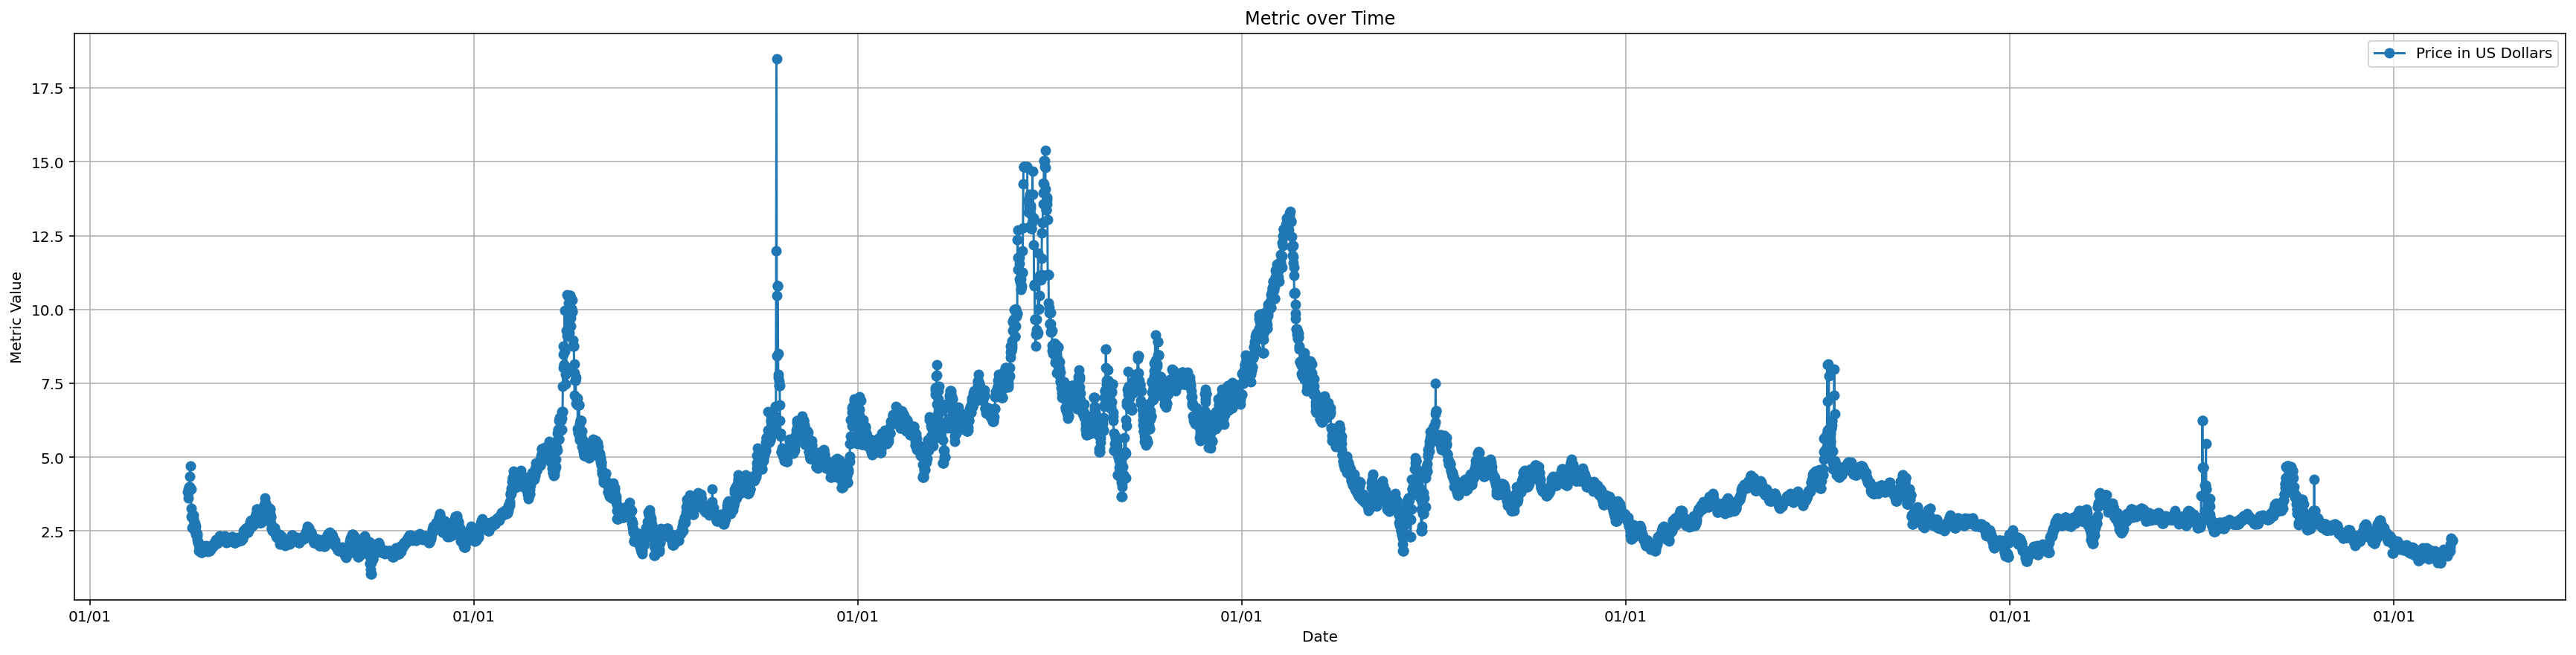

In [11]:
plot_metric_by_datetime(pd.DataFrame(df_target['Price']), 
                        labels=['Price in US Dollars'])

## Aggregate by time if needed

In [12]:
# # Aggregate by time interval
# df_target = aggregate_by_time(df_target, freq=aggregate_time, by='sum') 
# print(df_target.shape)
# df_target.head(10)

## Feature engineering

Because we are using deep learning feature engineering will be minimal.

- One-hot encode "is_weekend" and days of the week
- Add min and max values of row (optional)

Merge any datasets if needed

In [13]:
# # Merge data
# df_target = pd.merge(df_target, df_2, how='inner', left_index=True, right_index=True)
# df_target.head(10)

Naively fix abnormally high values by setting to a fixed ceiling value (e.g. 30x median)

In [14]:
cols_to_fix_anomalies = ["Price"]

def fix_anomalies(col_series):
    """
    Simplistically fix anomalies.  30x greater than median
    Arguments
    ---------
    col_series : pandas Series
        Data we wish to remove high values
        
    Returns
    -------
    col_data : pandas Series
        Data with any values 10 times greater than median 
        normalized to median values.
    """
    med = np.median(col_series)
    medx = med*30
    col_data = col_series.copy()
    col_data[col_data > medx] = medx
    return col_data

# Fix in df_agg any really high values - normalize to median value
for col in cols_to_fix_anomalies:
    df_target[col] = fix_anomalies(df_target[col])

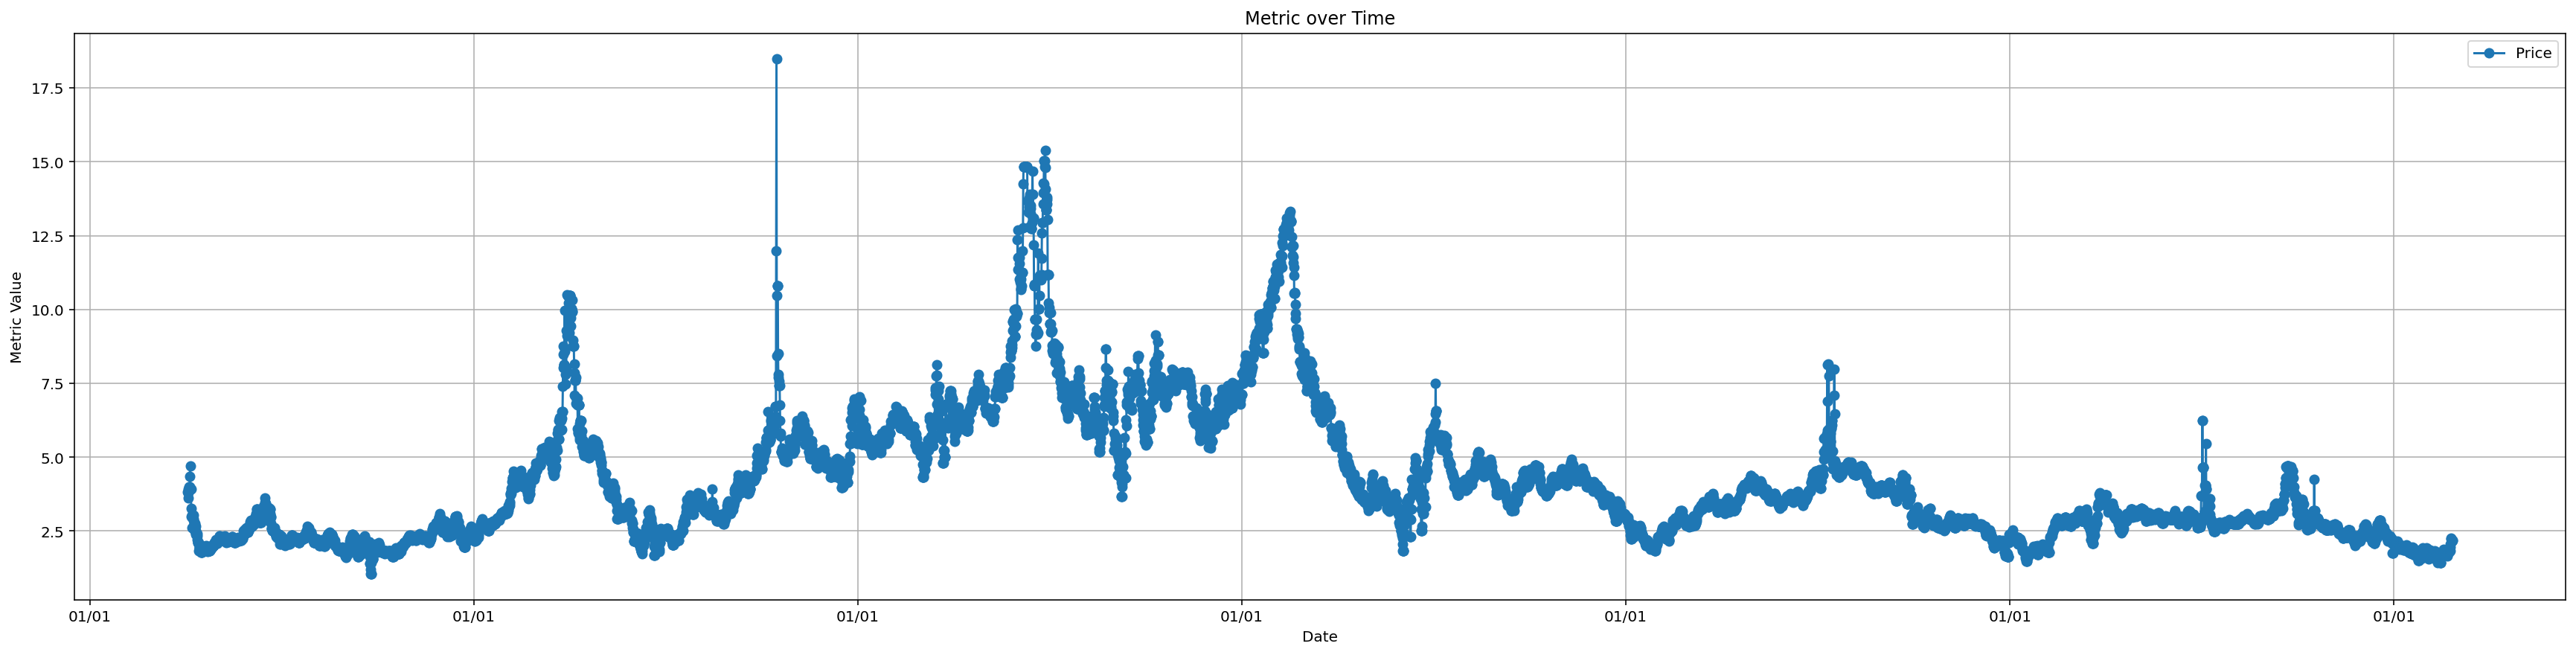

In [15]:
plot_metric_by_datetime(pd.DataFrame(df_target["Price"], index=df_target.index),
                       labels=["Price"])

Add lags

In [16]:
# # Add 0-n lags
# for i in range(7):
#     df_agg = add_lag(df_agg, target_variable='90th_time_to_schedule_secs', steps_back=i+1)
#     df_agg = add_lag(df_agg, target_variable='ProcessesRunningDuringSample', steps_back=i+1) 
#     df_agg = add_lag(df_agg, target_variable='ProcessesCreated', steps_back=i+1)

# Add weekly lag
df_target = add_lag(df_target, target_variable='Price', steps_back=7)
# Add 30 day lag
df_target = add_lag(df_target, target_variable='Price', steps_back=30)
    
# Save the current columns
saved_columns = df_target.columns

df_target.head(10)

,Price,Price_lag_7,Price_lag_30
1997-01-07,3.82,NaN,NaN
1997-01-08,3.80,NaN,NaN
1997-01-09,3.61,NaN,NaN
1997-01-10,3.92,NaN,NaN
1997-01-11,3.92,NaN,NaN
1997-01-12,3.92,NaN,NaN
1997-01-13,4.00,NaN,NaN
1997-01-14,4.01,3.82,NaN
1997-01-15,4.34,3.80,NaN
1997-01-16,4.71,3.61,NaN


In [17]:
# Add month, day of week and "is weekend" - one-hot encode
df_target = process_date(pd.DataFrame(df_target), saved_columns, indices=df_target.index)
df_target = encode_weekend(df_target)

# df_target.head()
df_target = encode_weekday(df_target)

# df_target.head()

In [18]:
# Drop any columns with NA values after merge
df_target.dropna(inplace=True)
print(df_target.shape)

time_index = df_target.index

(8588, 12)


In [19]:
def stack_data_for_algorithm(selected_data):
    """
    Reshape data to [samples, features] and stack
    sequences.
    
    :param selected_data: The input sequences [samples, features].
    :type selected_data: pandas dataframe
    :return: Output sequences [samples, features].
    :rtype: 2D numpy array
    """
    seqs = [np.array(selected_data.iloc[:, i]).reshape((selected_data.shape[0], 1)) for i in 
            range(selected_data.shape[1])]
    dataset = np.hstack(tuple(seqs))
    return dataset

dataset = stack_data_for_algorithm(df_target)
print(dataset.shape)

(8588, 12)


**Scale**

- Normalize or min-max scale (need to decrease the wide numerical range so that the LSTM will converge). Note: we can transform back to the original range with Python functions of the Normalizer or MinMaxScaler classes. If another scaling/normalizing method is used, make sure this is possible.
- We will need to save this scaler as a pickle file to use in the real world.

In [20]:
# Scale training data [0, 1]
scaler = preprocessing.MinMaxScaler((0,1))
scaler.fit(dataset)
dataset_transformed = scaler.transform(dataset)

print(dataset_transformed.shape)
pd.DataFrame(dataset_transformed)

(8588, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.083764,0.103844,0.158921,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.076879,0.098680,0.157774,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.076879,0.098680,0.146873,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.076879,0.098680,0.164659,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.078600,0.082616,0.164659,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8583,0.063110,0.044750,0.041882,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8584,0.063110,0.044750,0.047619,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8585,0.063110,0.044750,0.042456,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8586,0.064831,0.051635,0.042456,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prepare training dataset (and some for testing)


- Number of timesteps in = 1 (because we want to do online learning we only want 1 here)
- Number of timesteps out = see n_steps_out below for hour count (forecast horizon)

Here we will transform the dataset from [samples, features] into [samples, steps, features] - the shape which is used with the algorithm, LSTM.  The sequence splitting below uses the "walk-forward" method for creating the training dataset.

In [21]:
# multivariate multi-step encoder-decoder lstm example
# choose a number of time steps
n_steps_in, n_steps_out = 10, 10

# 
def split_sequences(sequences, n_steps_in, n_steps_out):
    """
    Split a multivariate sequence [samples, features] into
    a timeseries for forecasting [samples, steps, features]
    
    Arguments
    ---------
    sequences : 2D numpy array
        Timeseries data in format [samples, features]
    n_steps_in : int
        Number of timesteps as input to algorithm.
    n_steps_out : int
        Number of timesteps to forecast (output)
        
    Returns
    -------
    Tuple of numpy arrays ("X" and "y" or input featurs and labels/forecast)
    to serve as nput and output for algorithim
    """
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
 
# covert into input/output ("walk-forward" method)

# Shape into [number of samples, steps, features]
X, y = split_sequences(dataset_transformed, n_steps_in, n_steps_out)
# the dataset knows the number of features
n_features = X.shape[2]
print(X.shape)

# Split into train/test
test_amount = int(0.05*X.shape[0]) # 5% held-out
X_train, X_test, y_train, y_test = X[:-test_amount], X[-test_amount:], y[:-test_amount], y[-test_amount:]
print('Shape of datasets ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8569, 10, 12)
Shape of datasets  (8141, 10, 12) (428, 10, 12) (8141, 10, 12) (428, 10, 12)


## Train model

Use a simple encoder-decoder network.  This takes advantage of the long short term memory algorithm.

In [22]:
def create_model(n_steps_in, n_steps_out, n_features, learning_rate=0.01):
    """
    Define model:  Encoder/decoder LSTM
    
    Arguments
    ---------
    n_steps_in : int
        Number of time steps as input
    n_steps_out : int
        Number of time steps in forecast/output/prediction
    n_features : int
        Number of input features used for prediction
        
    Returns
    -------
    model : object (Keras Model)
        Compiled model architecture object, ready for training
    """
    adam = optimizers.Adam(lr=learning_rate)
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(optimizer=adam, loss='mse', metrics=['accuracy'])
    return model

In [23]:
def train(model, X_train, y_train, nepochs=40, batch_size=16):
    """
    Train the LSTM encoder-decoder model
    
    Arguments
    ---------
    model : object
        The model object to be used to train/store model 
        updates and architecture
    X_train : numpy array of shape [n samples, time steps input, n features]
        Training data
    y_train : numpy array of shape [n samples, time steps forecast, n features]
        The forecast data used as ground truth while training (how we optimize loss)
    nepochs : int
        Number of training epochs
    batch_size : int
        Mini-batch size
    
    Returns
    -------
    Trained model
    model : object (Keras model)
        Keras model object
    runtime : str
        Time the experiment ran and the weights folder name
    weightsfile : str
        String name of model on disk
    """
    run_time = datetime.datetime.now().strftime("%d-%b-%Y-%H-%M-%S")
    os.makedirs("weights" + os.sep + run_time, exist_ok=True)

    ## Create a TensorBoard instance with the path to the logs directory
    # tensorboard = TensorBoard(log_dir='logs/{}'.format(run_time))

    ## Checkpoint
    # filepath = os.path.join("weights", run_time, "weights-improvement-{epoch:02d}-{loss:.2f}.hdf5")
    # checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, mode='max')
    # callbacks_list = [tf.keras.callbacks.TensorBoard(os.path.join("logs", run_time)), checkpoint]

    # fit model
    history = model.fit(X_train, 
                        y_train,
                        batch_size=batch_size,
                        epochs=nepochs,
                        verbose=True)
    #, callbacks=callbacks_list)
    weightsfile = "weights-completed-bs{}-epochs{}-loss{}-nfeatures{}.hdf5".format(
                                        batch_size, 
                                        nepochs,
                                        '{:.4f}'.format(history.history['loss'][-1]),
                                        n_features)
    model.save_weights(os.path.join("weights", run_time, weightsfile))
    
    plt.plot(history.history['loss'])
    plt.title('model loss', size=16)
    plt.ylabel('loss', size=14)
    plt.xlabel('epoch', size=14)
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    return model, run_time, weightsfile

10 10 12




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





8141/8141 [==============================] - 6s 693us/step - loss: 0.1212 - acc: 0.6917
Epoch 2/20
8141/8141 [==============================] - 4s 522us/step - loss: 0.0939 - acc: 0.7466
Epoch 3/20
8141/8141 [==============================] - 4s 523us/step - loss: 0.0658 - acc: 0.8941
Epoch 4/20
8141/8141 [==============================] - 4s 530us/step - loss: 0.0477 - acc: 0.9284
Epoch 5/20
8141/8141 [==============================] - 4s 528us/step - loss: 0.0374 - acc: 0.8942
Epoch 6/20
8141/8141 [==============================] - 5s 557us/step - loss: 0.0320 - acc: 0.8815
Epoch 7/20
8141/8141 [==============================] - 5s 561us/step - loss: 0.0252 - acc: 0.8774
Epoch 8/20
8141/8141 [==============================] - 5s 558us/step - loss: 0.0201 - acc: 0.8380
Epoch 9/20
8141/8141 [==============================] - 5s 565us/step - loss: 0.0154 - acc: 0

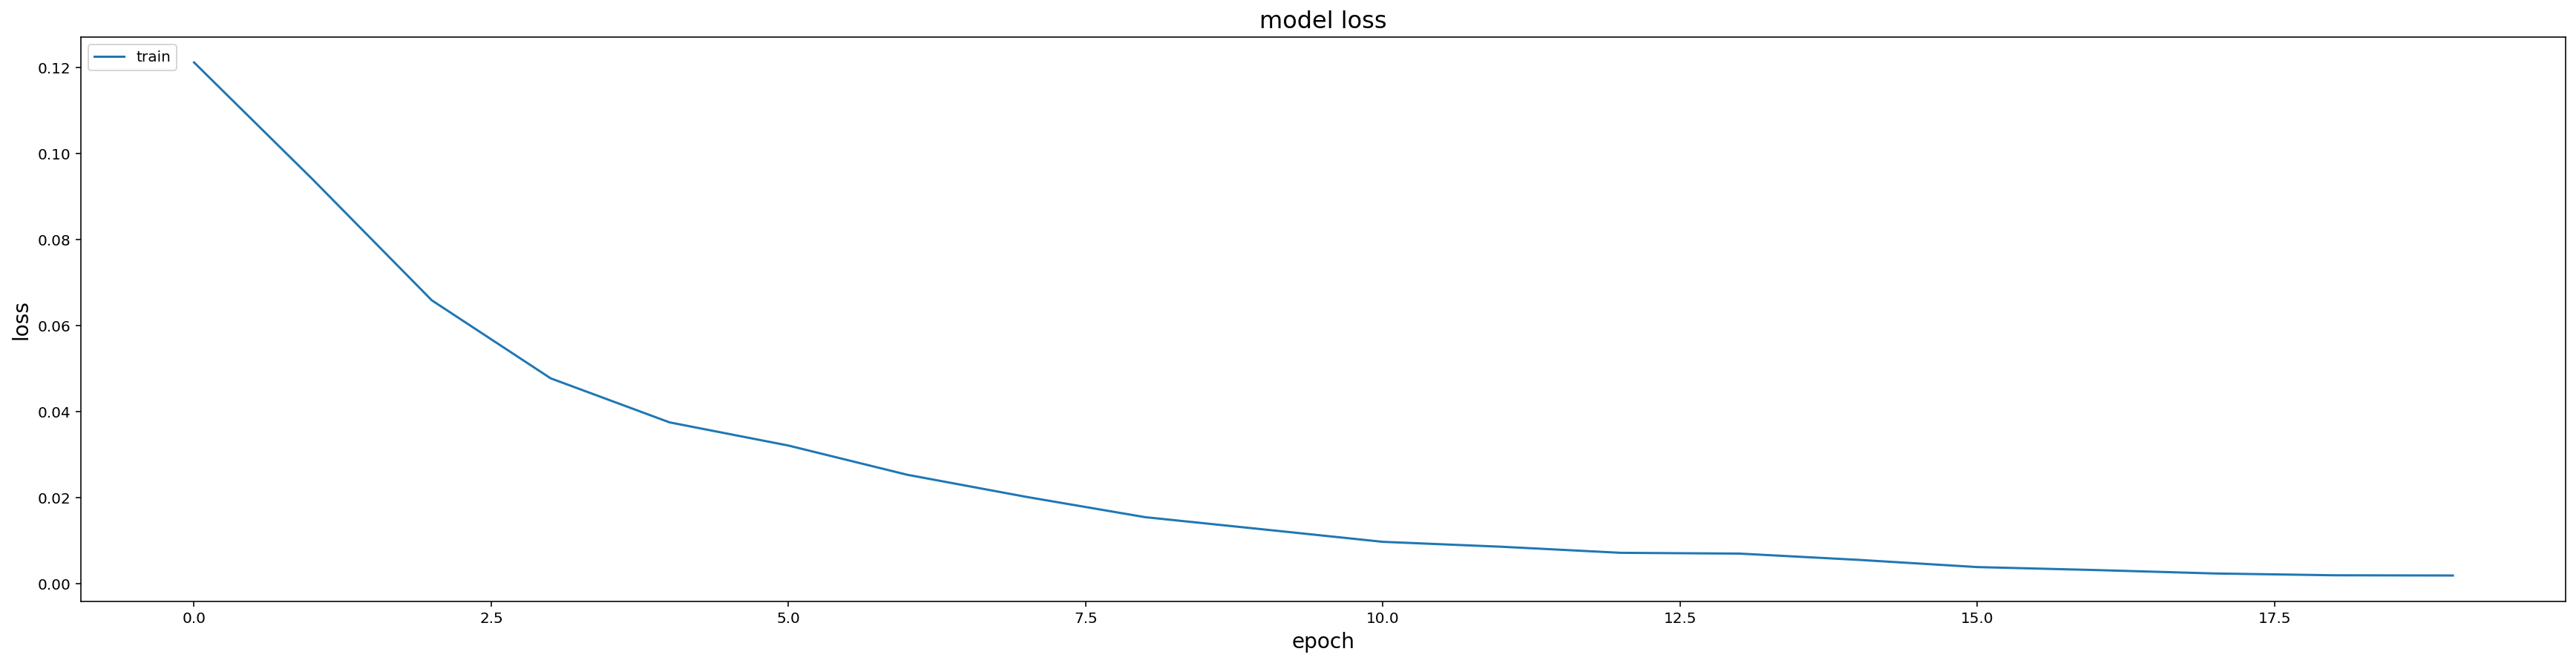

In [24]:
# Instantiate and train the model
print(n_steps_in, n_steps_out, n_features)
model = create_model(n_steps_in, n_steps_out, n_features, learning_rate=0.0001)
model, run_time, weightsfile = train(model, X_train, y_train, batch_size=32, nepochs=20)

## Explore predictions

In [25]:
def load_trained_model(weights_path, n_steps_in, n_steps_out, n_features):
    """
    Load a trained model into a Keras model object to use for prediction
    
    Arguments
    ---------
    weights_path : str
        Path to weights file (.h5) on system
    n_steps_in : int
        Number of time steps as input to algorithm
    n_steps_out : int
        Number of time steps in forecast/output/prediction
    n_features : int
        Number of input features used for prediction
    
    Returns
    -------
    model : object (Keras model)
        Keras model object loaded with weights from training experiment
    """
    model = create_model(n_steps_in, n_steps_out, n_features)
    model.load_weights(weights_path)
    return model

In [26]:
%%time
# Load specific model
# e.g. run_time='31-Oct-2020-16-10-24'

model = load_trained_model("weights/{}/{}".format(run_time, weightsfile), 
                           n_steps_in, 
                           n_steps_out, 
                           X_train.shape[2])

CPU times: user 2.29 s, sys: 343 ms, total: 2.63 s
Wall time: 751 ms


In [27]:
%%time
# demonstrate prediction for one sample
test_sample_ix = 0
yhat = model.predict(X_test[test_sample_ix].reshape((1, n_steps_in, n_features)), verbose=True)

1/1 [==============================] - 0s 207ms/step
CPU times: user 208 ms, sys: 18.6 ms, total: 226 ms
Wall time: 208 ms


In [28]:
# Calculate root mean squared error for this one test sample
rmse = math.sqrt(mean_squared_error(yhat[0], y_test[test_sample_ix]))
print('Root mean squared error = ', rmse)

Root mean squared error =  0.04478337637420601


In [29]:
print("Samples in X_test = {}".format(X_test.shape[0]))
print("Features: ", df_target.columns)

Samples in X_test = 428
Features:  Index(['Price', 'Price_lag_7', 'Price_lag_30', 'is_weekend_no',
       'is_weekend_yes', 'monday', 'tuesday', 'wednesday', 'thursday',
       'friday', 'saturday', 'sunday'],
      dtype='object')


In [30]:
def plot_result(pred, scaler, columns_no_days):
    """
    Plot predictions
    
    Arguments
    ---------
    pred : numpy array
        Prediction/forecast from one sample
    scaler : object; MinMaxScaler or Normalizer object (or otherwise chosen scaler)
        Object holding the transformation used to scale data
    """

    colors = list(mcolors.XKCD_COLORS)

    result_transformed = scaler.inverse_transform(pred)

    # Turn into a data frame and remove days and weekend columns/features
    columns_to_drop = ['is_weekend_no', 'is_weekend_yes', 'monday',
       'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
       'is_weekend_no', 'is_weekend_yes', 'monday', 'tuesday',
       'wednesday', 'thursday', 'friday', 'saturday', 'sunday']#, 'min', 'max']
    metric_df_pred = pd.DataFrame(result_transformed, columns=df_target.columns)
    metric_df_pred = metric_df_pred.drop(columns_to_drop, axis=1)
    metric_df_pred.columns = columns_no_days

    # Actual values to compare forecast to, scale back to original values
    actual = y_test[test_sample_ix+1:test_sample_ix+n_steps_out+1][0]
    actual = actual.reshape(n_steps_out, n_features)
    actual = scaler.inverse_transform(actual)
    # Turn into a dataframe and remove days and weekend features
    actual_df = pd.DataFrame(actual, columns=df_target.columns)
    actual_df = actual_df.drop(columns_to_drop, axis=1)
    actual_df.columns = columns_no_days
    
    
    for i in range(len(columns_no_days)):
        fig = plt.figure(figsize=(10,5))
        # Plot the prediction
        plt.plot(metric_df_pred.iloc[:,i], label="Predicted "+columns_no_days[i], linewidth=3, color=colors[i])
    
        # Plot the actual value
        plt.plot(actual_df.iloc[:,i], color="limegreen", linestyle='dashed', linewidth=3)
        
        # Label and legend
        plt.xlabel('Time steps {}'.format(aggregate_time))
        min_val = min(metric_df_pred.iloc[:,i])
        plt.ylim(bottom=min(0.0, min_val - min_val*0.1))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

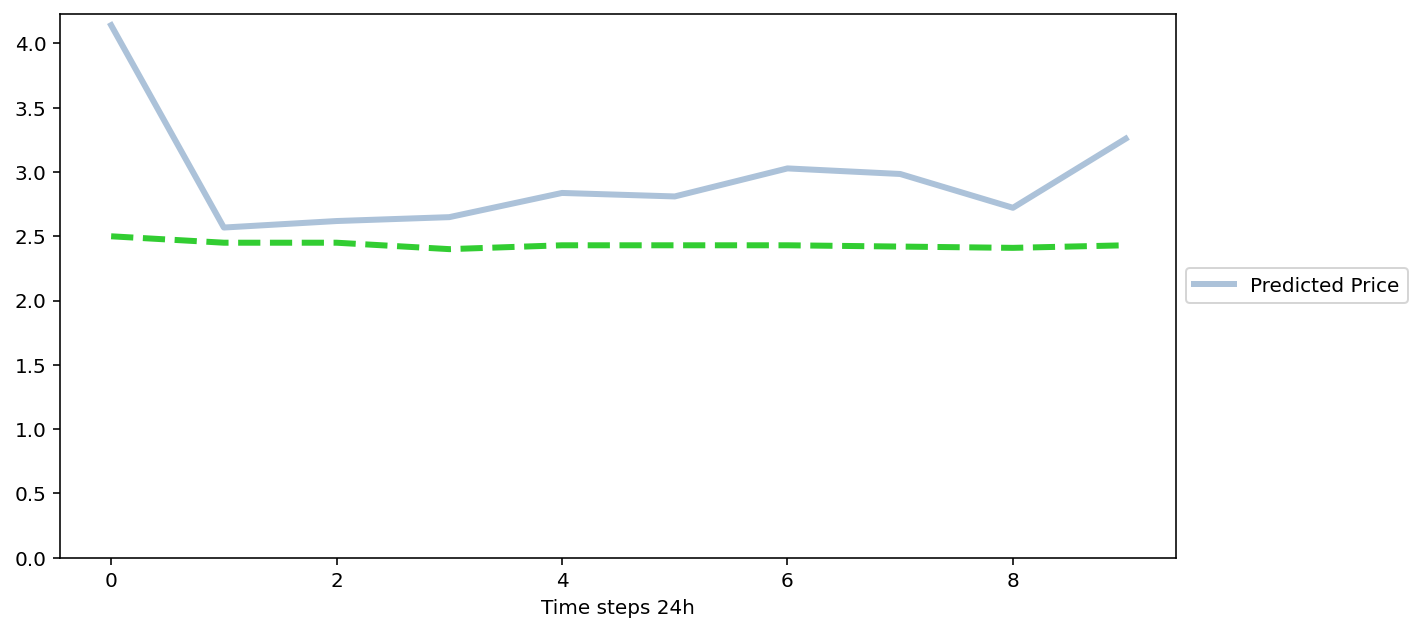

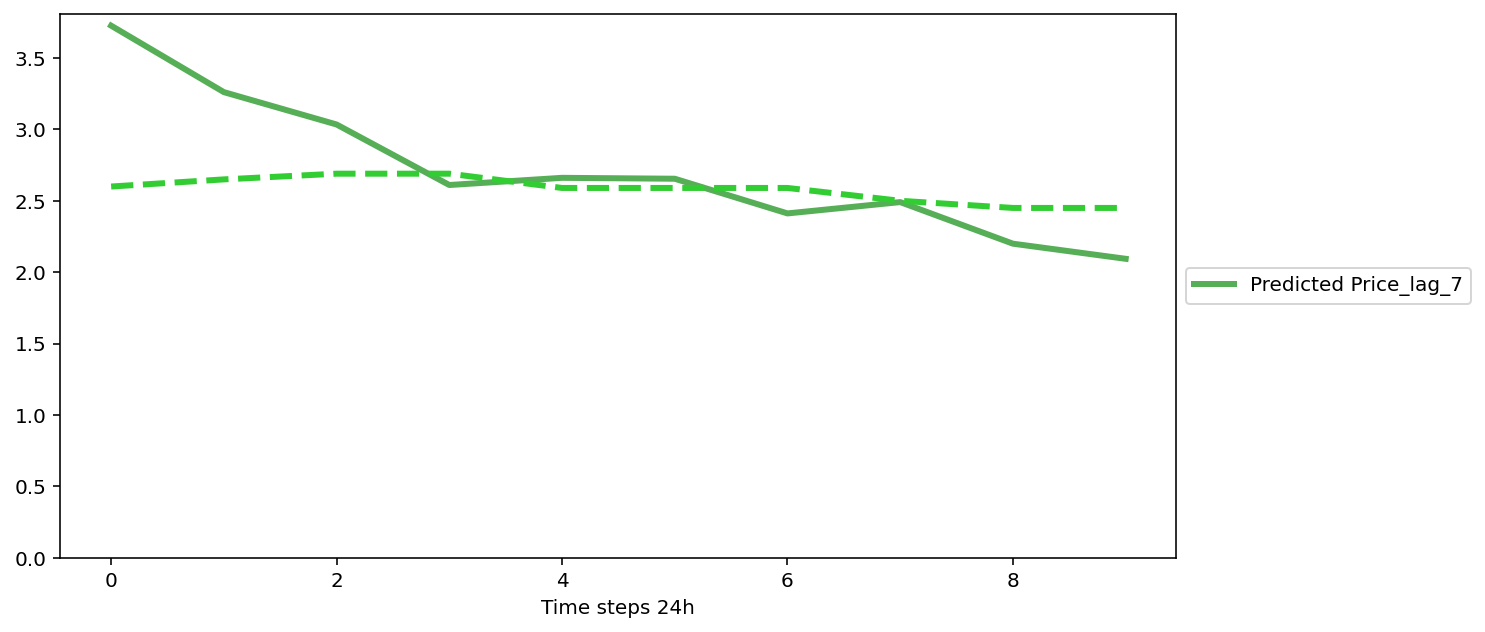

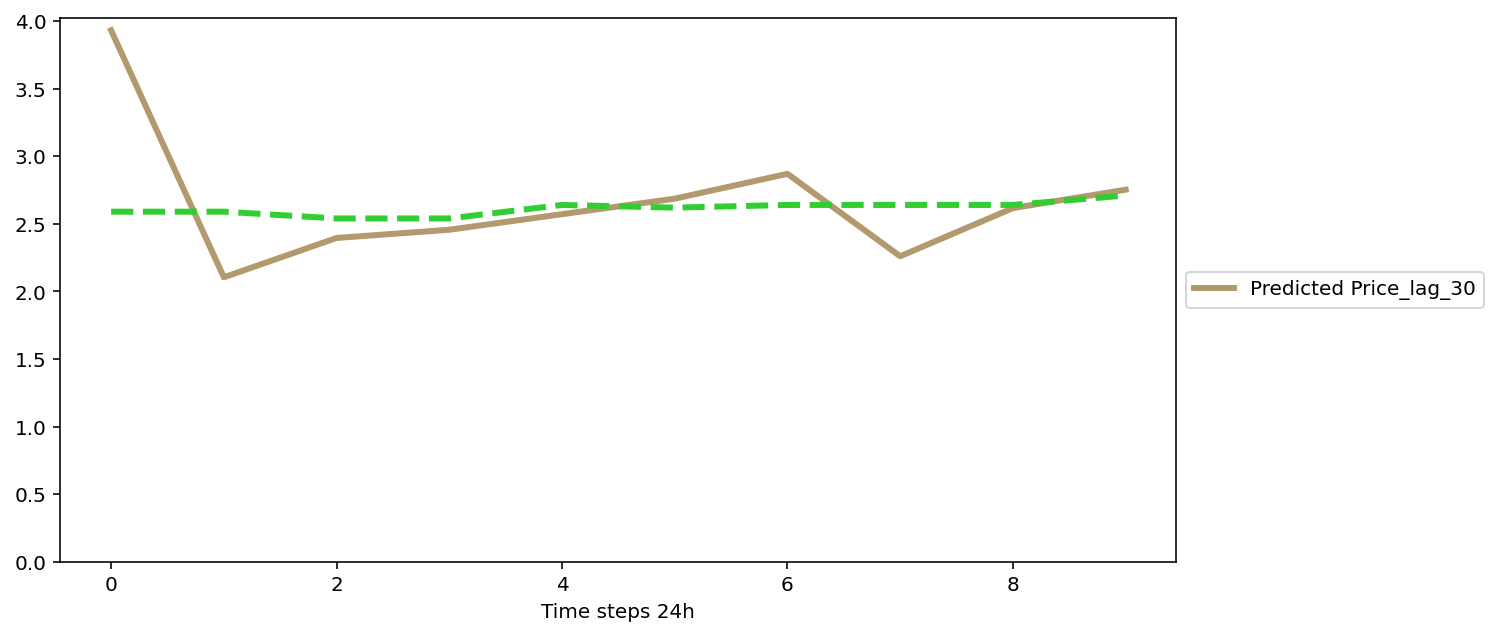

In [31]:
plot_result(yhat[0], scaler, saved_columns)

**Average RMSE**

In [32]:
# Collect all test RMSE values
rmse_scores = []
for i in range(len(X_test)):
    yhat = model.predict(X_test[i].reshape((1, n_steps_in, n_features)), verbose=False)
    # Calculate root mean squared error for this one test sample
    rmse = math.sqrt(mean_squared_error(yhat[0], y_test[i]))
    rmse_scores.append(rmse)

In [33]:
print("Mean RMSE of {:.4f} +/- {:.4f}".format(np.mean(rmse_scores), np.std(rmse_scores)))

Mean RMSE of 0.0402 +/- 0.0041


## Predict out-of-sample

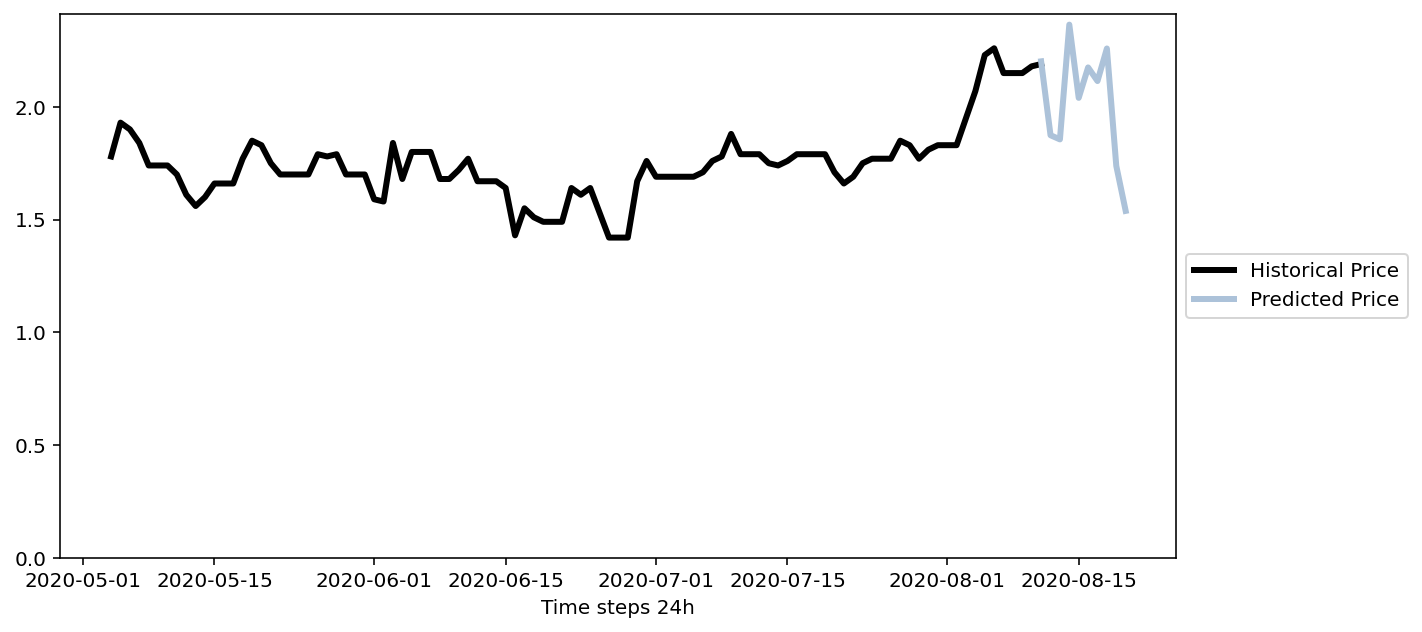

In [37]:
n_steps_in, n_steps_out = 10, 10

# Get last 10 steps
data_recent = df_target.iloc[-n_steps_in:]

# Scale
data_recent_transformed = scaler.transform(data_recent)
# print(pd.DataFrame(data_recent_transformed, columns=df_agg.columns))

# Shape into [number of samples, steps, features]
n_features = data_recent_transformed.shape[1]
X_past = data_recent_transformed.reshape((1, n_steps_in, n_features))

# Predict
forecast = model.predict(X_past)

# Scale back up and convert to DF
forecast = forecast.reshape((n_steps_out, n_features))
forecast = scaler.inverse_transform(forecast)
future_dates = pd.date_range(df_target.index[-1], periods=n_steps_out, freq='D')
forecast = pd.DataFrame(forecast, columns=df_target.columns, index=future_dates).iloc[:,:1]

# Plot
historical = df_target.iloc[-100:, :1] # get x steps back of historical data
colors = list(mcolors.XKCD_COLORS)
for i in range(forecast.shape[1]):
    fig = plt.figure(figsize=(10,5))
    
    # Plot df_agg historical data
    plt.plot(historical.iloc[:,i], label="Historical "+historical.columns[i], linewidth=3, color="black")
    
    # Plot the prediction
    plt.plot(forecast.iloc[:,i], label="Predicted "+forecast.columns[i], linewidth=3, color=colors[i])

    # Label and legend
    plt.xlabel('Time steps {}'.format(aggregate_time))
    min_val = min(forecast.iloc[:,i])
    plt.ylim(bottom=min(0.0, min_val - min_val*0.1))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


## Train on entire dataset

In [35]:
# # Instantiate and train the model on all data
# model_all = create_model(n_steps_in, n_steps_out, n_features, learning_rate=0.0001)
# model_all, run_time, weightsfile = train(model_all, X, y, batch_size=32, nepochs=10)

Plot predictions again with historical data

## Next

- More sophisticated way to remove outliers (see https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/)